## Dissociate distance and time during search paths

So far with the modelling approach, time and distance are equally good predictor of the firing rate of the neuron.

We need a more direct approach to dissociate time and distance. 

We can separate search navPaths into slow and fast paths. 

If time is an important factor (assuming enough running speed variability):
* The location of the firing fields should move backward during fast paths compared to slow paths.
* The shift in field position should increase with time and distance, so it will be more pronounced in fields that are further away from the start of the path

We will do this in a different jupyther notebook.


In [1]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy")

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 40 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 40/40 [00:27<00:00,  1.46it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [2]:
%%time
myProjectWithTrials = loadMyProjectWithTrials(myProject)
prepareSessionsForSpatialAnalysisProject(sSesList,myProjectWithTrials.sessionList,pose_file_extension = ".pose_kf.npy")

Loading: /adata/projects/autopi_ca1/results/myProjectWithTrials.pickle
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 40/40 [00:08<00:00,  4.70it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict
CPU times: user 15.4 s, sys: 5.71 s, total: 21.1 s
Wall time: 32.2 s


In [3]:
fn=myProject.dataPath+"/results/searchFields.pickle"
with open(fn, 'rb') as handle:
    searchFields = pickle.load(handle)

In [4]:
fn=myProject.dataPath+"/results/searchIFRDict.pickle"
with open(fn, 'rb') as handle:
    searchIFR = pickle.load(handle)

In [5]:
fn=myProject.dataPath+"/results/searchMapDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    myMaps=pickle.load(handle)

loading: /adata/projects/autopi_ca1/results/searchMapDict.pickle


## Example with one field

In [6]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def searchCellSummaryFig(gs,cellId,searchIFR,light="light",peaks=True):
    keys = list(searchIFR[cellId]["histo"].keys())
    key_prefix = keys[0].split("_")[0]
    key_dvs = set([k.split("_")[2]  for k in keys])
    
    condNames={"targetDistance":"Lever distance (cm)",
               "y": "Y coordinate (cm)",
               "iTime": "Time (sec)",
               "distanceProp":"Distance run (Prop)",
               "distance": "Distance run"}
    
    col=len(key_dvs)
    row = 1
    gs1 = gridspec.GridSpecFromSubplotSpec(row, col, subplot_spec=gs[0])    
    
    ## plot the rate x distance and rate x direction for light and dark

    for j,dv in enumerate(key_dvs):

        # single journey matrix
        ax = fig.add_subplot(gs1[j])
        cond = "{}_{}_{}".format(key_prefix,light,dv)
        oneHist = searchIFR[cellId]["histo"][cond]
        if light == "light":
            ax.plot(oneHist["bins"][:-1],oneHist["histo"],c="red",label="Raw")
        else:
            ax.plot(oneHist["bins"][:-1],oneHist["histo"],c="blue",label="Raw")
        ax.set_ylim(0,int(np.nanmax(oneHist["histo"]))+1)
        ax.set_xlabel(condNames[dv])
        ax.set_ylabel("Firing rate (Hz)")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if peaks ==True:
            peaksDet,smHist = detectFields(oneHist["histo"])
            ax.plot(oneHist["bins"][:-1],smHist,c="orange",label="Smoothed")
            peaksLoc=peaksDet[0]
            if len(peaksLoc)>0:
                #print(oneHist["histo"].shape,smHist.shape)
                #print(condNames[dv],light)
                #print(peaksDet)
                ax.scatter(oneHist["bins"][peaksLoc],smHist[peaksLoc],color="black",s=35)
        
        if j+1 == col:
            ax.legend()
        
def searchMatricesSummaryFig(gs,cellId,searchIFR,light="light"):
   
    keys = list(searchIFR[cellId]["matrix"].keys())
    key_prefix = keys[0].split("_")[0]
    key_dvs = set([k.split("_")[2]  for k in keys])
    
    condNames={"targetDistance":"Lever distance (cm)",
               "y": "Y coordinate (cm)",
               "iTime": "Time (sec)",
               "distanceProp":"Distance run (Prop)",
               "distance": "Distance run"}
    
    
    
    col=len(key_dvs)
    row = 1
    gs1 = gridspec.GridSpecFromSubplotSpec(row, col, subplot_spec=gs[0])    
    
    ## plot the rate x distance and rate x direction for light and dark

    for j,dv in enumerate(key_dvs):

        # single journey matrix
        ax = fig.add_subplot(gs1[j])
        cond = "{}_{}_{}".format(key_prefix,light,dv)
        oneMat = searchIFR[cellId]["matrix"][cond]
        plotIFRMatrix(ax,oneMat,showXLabel=True,xLabel=condNames[dv])
        
def plotIFRMatrix(ax,m ,showXLabel=True,xLabel=""):
    """
    Plot the matrix of rate per journey as a function of distance to lever
    """
    
    ax.imshow(m['matrix'],aspect="auto",interpolation="none",extent=[np.min(m["bins"]),np.max(m["bins"]),0,m["matrix"].shape[0]],origin="lower",cmap="jet")
    ax.set_ylabel("Journeys")
    if showXLabel:
        ax.set_xlabel(xLabel)
    else:
        ax.set_xlabel("")
    ax.yaxis.set_label_coords(-0.26, 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def searchPathsPlot(gs,cellId,ses, light="light"):
    
    sessionName=cellId.split("_")[0]
    mySes = myProjectWithTrials.getSession(sessionName=sessionName)
    navPathType="searchToLeverPath"
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0])    
    ax = fig.add_subplot(gs1[0])
    mySes.plotNavPath(ax=ax,navPathType=navPathType,light=light)
         
def plotMap(ax,myMap,title="",titleY=0.95):
    """
    Plot one 2D map
    """
    ax.imshow(myMap.T,origin="lower",cmap='jet',interpolation=None)
    ax.set_title(title,y=titleY)
    ax.axis('off')
    
def searchMapPlot(ax,cellId,myMaps,searchIFR,light="light"):
    prefix="searchToLeverPath"
    lights = ["light","dark"]
    index=np.argmax([ k==cellId for k in searchIFR.keys()])
    myMap=myMaps["searchToLeverPath_{}".format(light)][index]
    plotMap(ax,myMap,title="{:.2f} Hz".format(np.nanmax(myMap)))
    

def detectFields(oneHist,minPeak=7.5,smooth_sigma=2):
    """
    Detect 1D firing fields in a histogram using scipy.signal.find_peaks
    """
    height = np.nanmax(oneHist)/2
    if height < minPeak:
        height = minPeak 
        
    # smooth first
    smHist = gaussian_filter1d(oneHist, smooth_sigma)

    peakDet = find_peaks(smHist,height=height,width=1.5,distance=15,prominence=0.1,wlen=4)
    return peakDet,smHist

def searchCellSummary(gs,cellId,searchIFR,myProjectWithTrials, myMaps):
    """
    Plot for one neuron
    """
    cellIndex=np.argmax([ k==cellId for k in searchIFR.keys()])

    gs0 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[0],height_ratios=[0.03,.47,.03,.47])

    # We can get the axis for the light and dark
    gsLight = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs0[1])
    gsDark = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs0[3])
    gsTitleLight = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
    gsTitleDark = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[2])


    # put a title for our conditions
    for cond, gs in zip(["Light","Dark"],[gsTitleLight,gsTitleDark]):
        ax = fig.add_subplot(gs[0])
        ax.text(0.485,0.2,"{} {} {}".format(cond,cellId,cellIndex),fontsize=20)
        ax.axis('off')


    # we loop and create exactly the same figure for light and dark
    for cond, gs in zip(["light","dark"],[gsLight,gsDark]):
        ## path
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,0])
        searchPathsPlot(gs,cellId,ses = myProjectWithTrials,light=cond)        

        ## map
        ax = fig.add_subplot(gs[1,0])
        searchMapPlot(ax,cellId,myMaps,searchIFR,light=cond)

        ## histograms 
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,1:])
        searchCellSummaryFig(gs1,cellId,searchIFR,light=cond)

        ## matrices
        
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,1:])
        searchMatricesSummaryFig(gs1,cellId,searchIFR,light=cond)

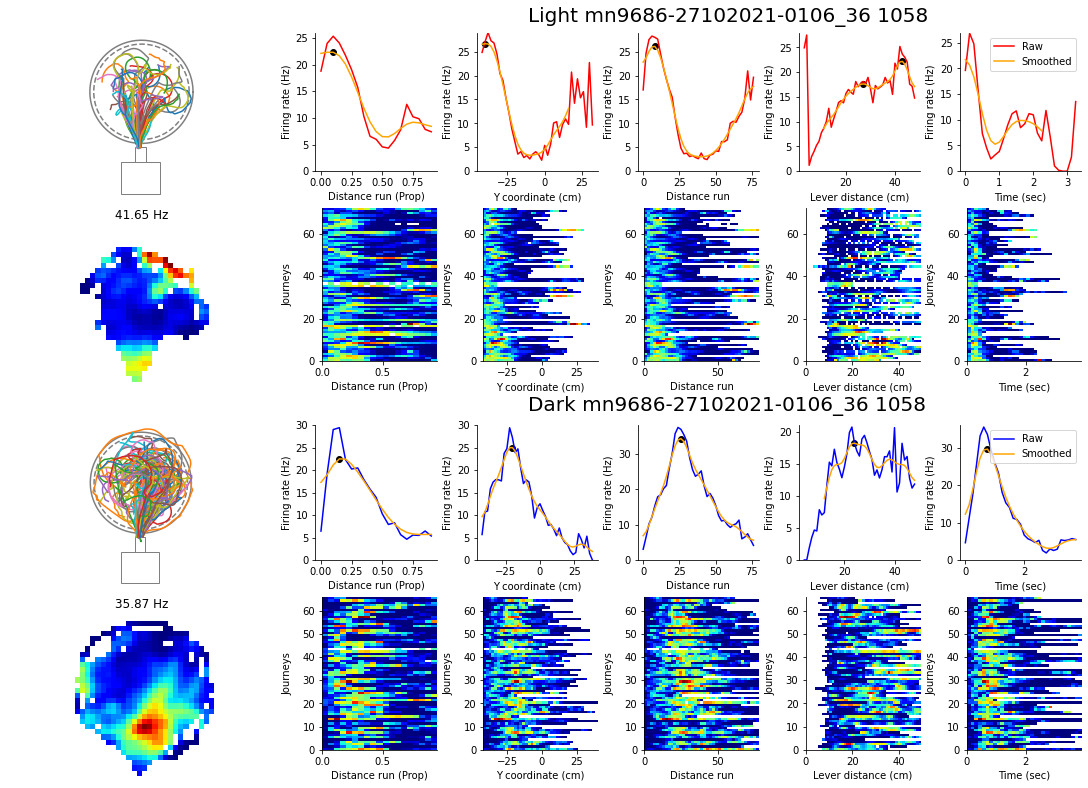

In [7]:
col=6
row=4
sizePerCol=2.5
sizePerRow=2.7       
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure

cellId="mn9686-27102021-0106_36"
searchCellSummary(gs,cellId,searchIFR,myProjectWithTrials, myMaps)

In [8]:
cellId="mn9686-27102021-0106_36"
light="dark"
pathType="searchToLeverPath"
searchFields[(searchFields.cellId==cellId)&(searchFields.light=="dark")]

,cellId,light,vari,peak_locs,min_left,min_right,peak_heights,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips,peak_ratio_left,peak_ratio_right
0,mn9686-27102021-0106_36,dark,distance,26.00,3.023547,4.111538,34.251120,2.037808,22.00,30.00,4.997708,33.232216,23.241713,28.239421,0.088276,0.120041
0,mn9686-27102021-0106_36,dark,iTime,0.75,4.610190,1.880204,29.643975,2.397256,0.50,1.00,0.283886,28.445347,0.568731,0.852618,0.155519,0.063426
0,mn9686-27102021-0106_36,dark,distanceProp,0.15,6.434743,4.618221,22.525160,1.212320,0.05,0.25,0.096386,21.919000,0.127586,0.223972,0.285669,0.205025


In [9]:
sesName = cellId.split("_")[0]
cluNo =  cellId.split("_")[1]
ses = myProjectWithTrials.getSession(sesName)
sSes = [ses for ses in sSesList if ses.name==sesName][0]
# load raw data from file
ifr, navs, inav = load_ifr_behavior(ses,verbose=False)


In [10]:
# select the navPaths of the relevant type
light="dark"
pathType="searchToLeverPath"
selNavs= navs[(navs.light==light)&(navs.type==pathType)]

In [11]:
# get the median speed of all paths, during the first meter of the path
def setSpeedCategory(selNavs,inav,slowCutOff=33,fastCutOff=66,verbose=False):
    selNavs["speed"] = [np.nanmedian(inav.speed[(inav.name==n)&(inav.distance < 60)]) for n in selNavs.name]
    ls,hs = np.percentile(selNavs["speed"],q=[slowCutOff,fastCutOff])
    if verbose:
        print("speed cutoffs:",ls,hs)
    selNavs["speedClass"] = "dn"
    selNavs.speedClass[selNavs.speed<ls] = "slow"
    selNavs.speedClass[selNavs.speed>hs] = "fast"
    if verbose:
        for t in ["fast","slow"]:
            print("median",t,":", np.median(selNavs.speed[selNavs.speedClass==t]))
setSpeedCategory(selNavs,inav)

We now have fast and slow trials. 

## Firing fields of slow and fast runs





In [73]:
from scipy.ndimage import gaussian_filter1d
from scipy import signal

def slowFastHisto(cellId):
    """
    Get the center of map and peak location for fast and slow runs
    """
    sesName = cellId.split("_")[0]
    cluNo =  cellId.split("_")[1]
    ses = myProjectWithTrials.getSession(sesName)
    sSes = [ses for ses in sSesList if ses.name==sesName][0]
    # load raw data from file
    ifr, navs, inav = load_ifr_behavior(ses,verbose=False)

    light="dark"
    pathType="searchToLeverPath"
    # select the navPaths of the relevant type
    selNavs= navs[(navs.light==light)&(navs.type==pathType)]
    # set fast/slow labels on each path
    setSpeedCategory(selNavs,inav,slowCutOff=25,fastCutOff=75)

    # get the IFR of the neuron
    cluIndex  = np.where(np.array([n.name for n in sSes.cg.neuron_list])==cluNo)[0][0]
    rate = ifr[0][cluIndex,:]
    time = ifr[1]

    # get the fast and slow paths
    fastSum= selNavs[selNavs.speedClass=="fast"]
    slowSum= selNavs[selNavs.speedClass=="slow"]
    fastInst = inav[inav.name.isin(fastSum.name)]
    slowInst = inav[inav.name.isin(slowSum.name)]


    # make a field histogram for fast and slow paths
    # get behavioral data and IFR for the test and train sets, using our neuronAutopi class
    fastNa = NeuronAutopi(name="fast",ifr=(rate,time),navPathSummary=fastSum,iNavPath=fastInst,trialElectro=None)
    slowNa = NeuronAutopi(name="slow",ifr=(rate,time),navPathSummary=slowSum,iNavPath=slowInst,trialElectro=None)


    #fastIfr, fastBeha = fastNa.getSingleNavPathData(navPathNames = fastSum.name) # we get 
    #slowIfr, slowBeha = slowNa.getSingleNavPathData(navPathNames = slowSum.name)


    ## create the histograms with the fields
    
    fastNa.navPathBehavioralHistogram(navPathType=pathType,light=light,nLeverMin = 1,
                                         behavioralVariable = "iTime",bins=np.arange(0,4,0.125)) 
    fastNa.navPathBehavioralMatrix(navPathType=pathType,light=light,nLeverMin = 1,
                                   behavioralVariable = "iTime",bins=np.arange(0,4,0.125)) # per journey
    fastNa.navPathBehavioralHistogram(navPathType=pathType,light=light,nLeverMin = 1,
                                      behavioralVariable = "distance",bins=np.arange(0,80,2))
    fastNa.navPathBehavioralMatrix(navPathType=pathType,light=light,nLeverMin = 1,
                                      behavioralVariable = "distance",bins=np.arange(0,80,2))

    slowNa.navPathBehavioralHistogram(navPathType=pathType,light=light,nLeverMin = 1,
                                     behavioralVariable = "iTime",bins=np.arange(0,4,0.125))
    slowNa.navPathBehavioralMatrix(navPathType=pathType,light=light,nLeverMin = 1,
                                     behavioralVariable = "iTime",bins=np.arange(0,4,0.125))
    
    slowNa.navPathBehavioralHistogram(navPathType=pathType,light=light,nLeverMin = 1,
                                      behavioralVariable = "distance",bins=np.arange(0,80,2))
    slowNa.navPathBehavioralMatrix(navPathType=pathType,light=light,nLeverMin = 1,
                                      behavioralVariable = "distance",bins=np.arange(0,80,2))
    
    
    return fastNa.navPathResultsDict,slowNa.navPathResultsDict


def ccSlowFast(fastNaDict,slowNaDict):
    """
    Calculate the cross-correlation of slow and fast maps
    """
    
    ## calculate the center of mass and peak of the histogram
    res = {}
    for cond in ["iTime","distance"]:
        # calculate the crosscorrelation
        hs = slowNaDict["histo"]["searchToLeverPath_dark_{}".format(cond)]
        hf = fastNaDict["histo"]["searchToLeverPath_dark_{}".format(cond)]
        cc= signal.correlate(hf["histo"],hs["histo"], mode='same')
        res[cond]=cc
        #plt.plot(cc)
        #plt.xlabel(cond)
        #plt.plot([len(cc)/2,len(cc)/2],[0,np.max(cc)])
        #plt.show()
    return res

We need to plot what we are analyzing to make sure we only have top quality data for this analysis. We don't have much variability in speed so any noise in the analysis with be detrimental.

In [74]:
fastNaDict, slowNaDict = slowFastHisto(cellId)

In [75]:
resCc = ccSlowFast(fastNaDict,slowNaDict)

In [89]:
def slowFastSummaryFigure(gs,cellId,searchIFR,myProjectWithTrials,myMaps,fastNaDict, slowNaDict,resCc):
    """
    Show the analysis on search fields during slow and fast search paths
    """
    gs0 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs[0])
    
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,0])
    searchPathsPlot(gs1,cellId,ses = myProjectWithTrials,light="dark")        

    ## map
    ax = fig.add_subplot(gs0[1,0])
    searchMapPlot(ax,cellId,myMaps,searchIFR,light="dark")
    
    # matrix
    ax = fig.add_subplot(gs0[0,1])
    m = searchIFR[cellId]["matrix"]["searchToLeverPath_dark_distance"]
    plotIFRMatrix(ax,m ,showXLabel=True,xLabel="")
    
    ax = fig.add_subplot(gs0[1,1])
    m = searchIFR[cellId]["matrix"]["searchToLeverPath_dark_iTime"]
    plotIFRMatrix(ax,m ,showXLabel=True,xLabel="")
    
    
    ax = fig.add_subplot(gs0[0,2]) 
    m = fastNaDict["matrix"]["searchToLeverPath_dark_distance"]
    M = slowNaDict["matrix"]["searchToLeverPath_dark_distance"]["matrix"]
    n = slowNaDict["matrix"]["searchToLeverPath_dark_distance"]
    N = slowNaDict["matrix"]["searchToLeverPath_dark_distance"]
    o = np.stack([m,n])
    print(m.shape,o.shape)
    #plotIFRMatrix(ax,o ,showXLabel=True,xLabel="")
    

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

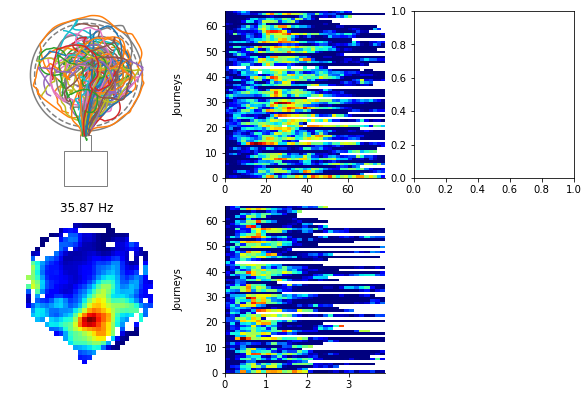

In [90]:
col=5
row=2
sizePerCol=2.5
sizePerRow=2.7       
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure

cellId="mn9686-27102021-0106_36"
slowFastSummaryFigure(gs,cellId,searchIFR,myProjectWithTrials, myMaps,fastNaDict, slowNaDict,resCc)

In [64]:
fastNaDict["histo"]['searchToLeverPath_dark_iTime']

{'histo': array([ 8.6139798 , 17.52877846, 19.78127101, 30.3940555 , 34.23273312,
        36.9501786 , 32.62499655, 25.84700703, 25.70067454, 21.23705885,
        13.71224385,  9.86110849, 14.30338892, 13.30693602, 10.84360191,
        12.70431488,  6.62830322,  5.36451564,  6.37154465,  4.66914944,
         5.04742547,  5.0166571 ,  3.5744619 ,  4.90160017,  5.30484513,
         4.08161958,  6.99126719,  9.85992578,  6.84806756,  2.68788775,
         5.97990612]),
 'bins': array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
        1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
        2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 ,
        3.375, 3.5  , 3.625, 3.75 , 3.875])}

Calculate the rate X distance and rate X iTime for fast and slow path for neuron with fields.

In [36]:
myList = [ slowFastHisto(cellId) for cellId in searchFields.cellId[searchFields.light=="dark"].unique()]     

Calculate the crosscorrelation between fast and slow histograms

In [37]:
ccRes = [ccSlowFast(fastNaDict,slowNaDict) for fastNaDict,slowNaDict in myList]  

In [55]:
iTimeCc = np.stack([d["iTime"] for d in ccRes])
distanceCc = np.stack([d["distance"] for d in ccRes])

In [58]:
iTimeCc = iTimeCc/np.nanmax(iTimeCc,axis=1).reshape(-1,1)
distanceCc = distanceCc/np.nanmax(distanceCc,axis=1).reshape(-1,1)

/tmp/ipykernel_51010/1359833329.py:1: RuntimeWarning: All-NaN slice encountered
  iTimeCc = iTimeCc/np.nanmax(iTimeCc,axis=1).reshape(-1,1)
/tmp/ipykernel_51010/1359833329.py:2: RuntimeWarning: All-NaN slice encountered
  distanceCc = distanceCc/np.nanmax(distanceCc,axis=1).reshape(-1,1)


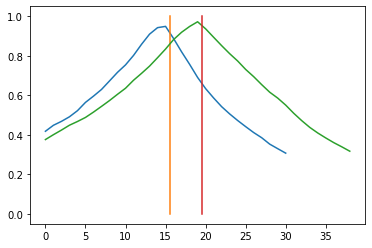

In [61]:
plt.plot(np.nanmean(iTimeCc,axis=0))
plt.plot([iTimeCc.shape[1]/2,iTimeCc.shape[1]/2],[0,np.nanmax(iTimeCc)])
plt.plot(np.nanmean(distanceCc,axis=0))
plt.plot([distanceCc.shape[1]/2,distanceCc.shape[1]/2],[0,np.nanmax(distanceCc)])

In [33]:
from sklearn.model_selection import train_test_split
from neuronAutopi import NeuronAutopi
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


def mse_ifr_prediction(trainIfr,trainBeha,testIfr,testBeha,var=["distance"]):
    """
    Function to predict the IFR from a behavioral variable using a multi-layer peceptron model
    
    A train and test sets are used. 
    Returns the MSE for the train and test set is returned
    """
    yTrain = trainIfr
    XTrain = trainBeha[var].to_numpy().reshape(-1,len(var))
    yTest = testIfr
    XTest = testBeha[var].to_numpy().reshape(-1,len(var))

    # remove entries with nan in behavioral data, ifr does not have nans
    keep= ~np.isnan(XTrain[:,0])
    XTrain = XTrain[keep,:]
    yTrain = yTrain[keep]
    keep= ~np.isnan(XTest[:,0])
    XTest = XTest[keep,:]
    yTest = yTest[keep]
    
    # train a Multi-layer Perceptron regressor.
    regr = MLPRegressor(random_state=1,hidden_layer_sizes=(6,12,6), max_iter=5000).fit(XTrain, yTrain)

    y_pred_train = regr.predict(XTrain)
    mse_train = mean_squared_error(yTrain, y_pred_train)
    y_pred_test = regr.predict(XTest)
    mse_test = mean_squared_error(yTest, y_pred_test)
    
    return mse_train, mse_test


def field_IFR_prediction(cellId,light,pathType,myProjectWithTrial,sSesList, behavioralVariables=[["distance"],["iTime"]]):
    """
    Function to see how well behavioral variables can predict the IFR of a neuron
    
    """

    sesName = cellId.split("_")[0]
    cluNo =  cellId.split("_")[1]
    ses = myProjectWithTrials.getSession(sesName)
    sSes = [ses for ses in sSesList if ses.name==sesName][0]
    # load raw data from file
    ifr, navs, inav = load_ifr_behavior(ses,verbose=False)
    
    # select the navPaths of the relevant type
    selNavs= navs[(navs.light==light)&(navs.type==pathType)]
    # set fast/slow labels on each path
    setSpeedCategory(selNavs,inav)
    
    # get the IFR of the neuron
    cluIndex  = np.where(np.array([n.name for n in sSes.cg.neuron_list])==cluNo)[0][0]
    rate = ifr[0][cluIndex,:]
    time = ifr[1]
    
    # split the data into training and test sets
    train, test = selNavs.name[selNavs.speedClass=="slow"],selNavs.name[selNavs.speedClass=="fast"]
    
    #train_test_split(selNavs.name, test_size=0.33, random_state=42)
    trainInst = inav[inav.name.isin(train)]
    trainSum = selNavs[selNavs.name.isin(train)]

    testInst = inav[inav.name.isin(test)]
    testSum = selNavs[selNavs.name.isin(test)]

    
    # get behavioral data and IFR for the test and train sets, using our neuronAutopi class
    trainNa = NeuronAutopi(name="train",ifr=(rate,time),navPathSummary=trainSum,iNavPath=trainInst,trialElectro=None)
    testNa = NeuronAutopi(name="test",ifr=(rate,time),navPathSummary=testSum,iNavPath=testInst,trialElectro=None)
    trainIfr, trainBeha = trainNa.getSingleNavPathData(navPathNames = train)
    testIfr, testBeha = testNa.getSingleNavPathData(navPathNames = test)

    res = pd.DataFrame()
    res = pd.DataFrame({"cellId":[cellId],"light":[light],"pathType":[pathType]})
    res["test_n"] = [testSum.shape[0]]
    res["train_n"] = [trainSum.shape[0]]
        
    ## model the neuron using the train set and predict the ifr test
    for behav in behavioralVariables:
        mse_train,mse_test = mse_ifr_prediction(trainIfr,trainBeha,testIfr,testBeha,var=behav)
        res["{}_mse_train".format('-'.join(behav))]=[mse_train]
        res["{}_mse_test".format("-".join(behav))]=[mse_test]

    return res

In [34]:
field_IFR_prediction(cellId,light,pathType,myProjectWithTrials,sSesList,
                     behavioralVariables=[["distance"],["iTime"]])

speed cutoffs: 26.410469806360503 31.047059617373325
median fast : 34.1366170709496
median slow : 24.634674283571705


,cellId,light,pathType,test_n,train_n,distance_mse_train,distance_mse_test,iTime_mse_train,iTime_mse_test
0,mn9686-01112021-0106_242,dark,searchToLeverPath,20,20,261.728604,298.655085,251.113284,322.393018


In [35]:
res = pd.DataFrame()
for cellId in tqdm(searchFields.cellId[searchFields.light=="dark"].unique()):
    res = pd.concat([res,field_IFR_prediction(cellId,light,pathType,myProjectWithTrials,sSesList,
                    behavioralVariables=[["distance"],["iTime"]])])
res.index = np.arange(len(res.cellId))

  0%|                                                                                                                          | 0/108 [00:00<?, ?it/s]

speed cutoffs: 23.983742337329353 30.49147253850093
median fast : 33.36492331774179
median slow : 22.05343916955973


  1%|█                                                                                                                 | 1/108 [00:03<07:00,  3.93s/it]

speed cutoffs: 23.983742337329353 30.49147253850093
median fast : 33.36492331774179
median slow : 22.05343916955973


  2%|██                                                                                                                | 2/108 [00:07<06:46,  3.84s/it]

speed cutoffs: 23.983742337329353 30.49147253850093
median fast : 33.36492331774179
median slow : 22.05343916955973


  3%|███▏                                                                                                              | 3/108 [00:10<05:37,  3.22s/it]

speed cutoffs: 20.046788764208742 26.062300887525403
median fast : 28.354384370155305
median slow : 18.81900795476053


  4%|████▏                                                                                                             | 4/108 [00:13<05:26,  3.14s/it]

speed cutoffs: 20.046788764208742 26.062300887525403
median fast : 28.354384370155305
median slow : 18.81900795476053


  5%|█████▎                                                                                                            | 5/108 [00:14<04:29,  2.61s/it]

speed cutoffs: 20.046788764208742 26.062300887525403
median fast : 28.354384370155305
median slow : 18.81900795476053


  6%|██████▎                                                                                                           | 6/108 [00:17<04:31,  2.66s/it]

speed cutoffs: 20.046788764208742 26.062300887525403
median fast : 28.354384370155305
median slow : 18.81900795476053


  6%|███████▍                                                                                                          | 7/108 [00:20<04:43,  2.81s/it]

speed cutoffs: 20.046788764208742 26.062300887525403
median fast : 28.354384370155305
median slow : 18.81900795476053


  7%|████████▍                                                                                                         | 8/108 [00:25<05:29,  3.29s/it]

speed cutoffs: 24.580260713574468 29.926255942515667
median fast : 32.17907389004169
median slow : 22.765178441548322


  8%|█████████▌                                                                                                        | 9/108 [00:27<04:48,  2.92s/it]

speed cutoffs: 24.580260713574468 29.926255942515667
median fast : 32.17907389004169
median slow : 22.765178441548322


  9%|██████████▍                                                                                                      | 10/108 [00:30<04:48,  2.95s/it]

speed cutoffs: 28.00198480543643 33.94789514484414
median fast : 36.64298098820072
median slow : 25.54045804212612


 10%|███████████▌                                                                                                     | 11/108 [00:32<04:26,  2.75s/it]

speed cutoffs: 19.360924353440453 25.95279054960847
median fast : 27.185712404922157
median slow : 16.459941993322904


 11%|████████████▌                                                                                                    | 12/108 [00:35<04:33,  2.85s/it]

speed cutoffs: 17.881281306387077 21.254710557516972
median fast : 21.898473246471674
median slow : 17.53671349542038


 12%|█████████████▌                                                                                                   | 13/108 [00:39<05:05,  3.22s/it]

speed cutoffs: 17.881281306387077 21.254710557516972
median fast : 21.898473246471674
median slow : 17.53671349542038


 13%|██████████████▋                                                                                                  | 14/108 [00:42<04:59,  3.18s/it]

speed cutoffs: 17.393290758414622 21.684386605234128
median fast : 22.44239481402046
median slow : 15.04778954249063


 14%|███████████████▋                                                                                                 | 15/108 [00:44<04:25,  2.86s/it]

speed cutoffs: 18.326628994284924 21.736807695674415
median fast : 23.078462344395497
median slow : 16.78468521550795


 15%|████████████████▋                                                                                                | 16/108 [00:47<04:05,  2.67s/it]

speed cutoffs: 15.979319312868105 20.599571985675304
median fast : 21.44458311642901
median slow : 14.53997607055926


 16%|█████████████████▊                                                                                               | 17/108 [00:49<03:51,  2.54s/it]

speed cutoffs: 15.979319312868105 20.599571985675304
median fast : 21.44458311642901
median slow : 14.53997607055926


 17%|██████████████████▊                                                                                              | 18/108 [00:51<03:31,  2.34s/it]

speed cutoffs: 14.53038913821541 22.958718305853175
median fast : 25.180602901318338
median slow : 10.612994994837708


 18%|███████████████████▉                                                                                             | 19/108 [00:52<03:12,  2.17s/it]

speed cutoffs: 28.493631234255275 33.33805850179729
median fast : 36.19905070441301
median slow : 21.901932322163887


 19%|████████████████████▉                                                                                            | 20/108 [00:56<03:43,  2.53s/it]

speed cutoffs: 28.493631234255275 33.33805850179729
median fast : 36.19905070441301
median slow : 21.901932322163887


 19%|█████████████████████▉                                                                                           | 21/108 [00:59<03:57,  2.73s/it]

speed cutoffs: 24.47795696831016 32.9743505856641
median fast : 34.710358352864915
median slow : 19.17201196461199


 20%|███████████████████████                                                                                          | 22/108 [01:01<03:24,  2.37s/it]

speed cutoffs: 24.47795696831016 32.9743505856641
median fast : 34.710358352864915
median slow : 19.17201196461199


 21%|████████████████████████                                                                                         | 23/108 [01:05<04:11,  2.96s/it]

speed cutoffs: 24.47795696831016 32.9743505856641
median fast : 34.710358352864915
median slow : 19.17201196461199


 22%|█████████████████████████                                                                                        | 24/108 [01:07<03:55,  2.80s/it]

speed cutoffs: 24.47795696831016 32.9743505856641
median fast : 34.710358352864915
median slow : 19.17201196461199


 23%|██████████████████████████▏                                                                                      | 25/108 [01:14<05:40,  4.10s/it]

speed cutoffs: 23.44240013067588 31.54014756294668
median fast : 34.34107094008817
median slow : 21.60626463305306


 24%|███████████████████████████▏                                                                                     | 26/108 [01:20<06:03,  4.44s/it]

speed cutoffs: 23.44240013067588 31.54014756294668
median fast : 34.34107094008817
median slow : 21.60626463305306


 25%|████████████████████████████▎                                                                                    | 27/108 [01:25<06:10,  4.57s/it]

speed cutoffs: 20.886799317203813 28.49054576504284
median fast : 32.195347520835426
median slow : 16.991366556597217


 26%|█████████████████████████████▎                                                                                   | 28/108 [01:29<05:53,  4.42s/it]

speed cutoffs: 19.86817261389566 25.317466660057008
median fast : 28.23906944501244
median slow : 17.42381671807074


 27%|██████████████████████████████▎                                                                                  | 29/108 [01:31<04:59,  3.79s/it]

speed cutoffs: 20.211198541254937 24.99967827488853
median fast : 26.795414924087524
median slow : 18.202573998460085


 28%|███████████████████████████████▍                                                                                 | 30/108 [01:35<04:51,  3.74s/it]

speed cutoffs: 20.211198541254937 24.99967827488853
median fast : 26.795414924087524
median slow : 18.202573998460085


 29%|████████████████████████████████▍                                                                                | 31/108 [01:38<04:29,  3.51s/it]

speed cutoffs: 20.211198541254937 24.99967827488853
median fast : 26.795414924087524
median slow : 18.202573998460085


 30%|█████████████████████████████████▍                                                                               | 32/108 [01:40<03:56,  3.12s/it]

speed cutoffs: 20.211198541254937 24.99967827488853
median fast : 26.795414924087524
median slow : 18.202573998460085


 31%|██████████████████████████████████▌                                                                              | 33/108 [01:43<03:55,  3.14s/it]

speed cutoffs: 20.211198541254937 24.99967827488853
median fast : 26.795414924087524
median slow : 18.202573998460085


 31%|███████████████████████████████████▌                                                                             | 34/108 [01:47<04:05,  3.32s/it]

speed cutoffs: 20.211198541254937 24.99967827488853
median fast : 26.795414924087524
median slow : 18.202573998460085


 32%|████████████████████████████████████▌                                                                            | 35/108 [01:50<04:08,  3.40s/it]

speed cutoffs: 23.84024198915677 26.66655160082922
median fast : 29.41058988049422
median slow : 21.91857226242925


 33%|█████████████████████████████████████▋                                                                           | 36/108 [01:53<03:43,  3.11s/it]

speed cutoffs: 23.84024198915677 26.66655160082922
median fast : 29.41058988049422
median slow : 21.91857226242925


 34%|██████████████████████████████████████▋                                                                          | 37/108 [01:57<03:56,  3.34s/it]

speed cutoffs: 23.84024198915677 26.66655160082922
median fast : 29.41058988049422
median slow : 21.91857226242925


 35%|███████████████████████████████████████▊                                                                         | 38/108 [02:01<04:25,  3.79s/it]

speed cutoffs: 22.947080329329687 28.790262782660335
median fast : 29.84581459784649
median slow : 19.454898751054472


 36%|████████████████████████████████████████▊                                                                        | 39/108 [02:06<04:32,  3.95s/it]

speed cutoffs: 22.947080329329687 28.790262782660335
median fast : 29.84581459784649
median slow : 19.454898751054472


 37%|█████████████████████████████████████████▊                                                                       | 40/108 [02:09<04:08,  3.65s/it]

speed cutoffs: 15.742996618898268 20.85896623214042
median fast : 22.505702424056636
median slow : 14.564364584047787


 38%|██████████████████████████████████████████▉                                                                      | 41/108 [02:11<03:47,  3.40s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 39%|███████████████████████████████████████████▉                                                                     | 42/108 [02:13<03:08,  2.86s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 40%|████████████████████████████████████████████▉                                                                    | 43/108 [02:16<03:13,  2.97s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 41%|██████████████████████████████████████████████                                                                   | 44/108 [02:20<03:23,  3.19s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 42%|███████████████████████████████████████████████                                                                  | 45/108 [02:25<03:51,  3.67s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 43%|████████████████████████████████████████████████▏                                                                | 46/108 [02:27<03:26,  3.32s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 44%|█████████████████████████████████████████████████▏                                                               | 47/108 [02:30<03:06,  3.06s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 44%|██████████████████████████████████████████████████▏                                                              | 48/108 [02:34<03:18,  3.30s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 45%|███████████████████████████████████████████████████▎                                                             | 49/108 [02:38<03:27,  3.51s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 46%|████████████████████████████████████████████████████▎                                                            | 50/108 [02:40<03:02,  3.15s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 47%|█████████████████████████████████████████████████████▎                                                           | 51/108 [02:43<03:05,  3.25s/it]

speed cutoffs: 19.017191644056936 23.632285277346632
median fast : 24.324471711852716
median slow : 18.39860328586802


 48%|██████████████████████████████████████████████████████▍                                                          | 52/108 [02:46<02:50,  3.04s/it]

speed cutoffs: 19.467262509125632 23.163306940421336
median fast : 24.471254475553852
median slow : 18.362198243063382


 49%|███████████████████████████████████████████████████████▍                                                         | 53/108 [02:48<02:29,  2.72s/it]

speed cutoffs: 19.467262509125632 23.163306940421336
median fast : 24.471254475553852
median slow : 18.362198243063382


 50%|████████████████████████████████████████████████████████▌                                                        | 54/108 [02:51<02:37,  2.91s/it]

speed cutoffs: 19.467262509125632 23.163306940421336
median fast : 24.471254475553852
median slow : 18.362198243063382


 51%|█████████████████████████████████████████████████████████▌                                                       | 55/108 [02:54<02:27,  2.79s/it]

speed cutoffs: 19.467262509125632 23.163306940421336
median fast : 24.471254475553852
median slow : 18.362198243063382


 52%|██████████████████████████████████████████████████████████▌                                                      | 56/108 [02:57<02:33,  2.96s/it]

speed cutoffs: 19.467262509125632 23.163306940421336
median fast : 24.471254475553852
median slow : 18.362198243063382


 53%|███████████████████████████████████████████████████████████▋                                                     | 57/108 [03:00<02:29,  2.92s/it]

speed cutoffs: 19.467262509125632 23.163306940421336
median fast : 24.471254475553852
median slow : 18.362198243063382


 54%|████████████████████████████████████████████████████████████▋                                                    | 58/108 [03:02<02:14,  2.70s/it]

speed cutoffs: 17.999699921884947 21.24939117217132
median fast : 22.655672477043648
median slow : 16.104155305994144


 55%|█████████████████████████████████████████████████████████████▋                                                   | 59/108 [03:06<02:27,  3.02s/it]

speed cutoffs: 17.999699921884947 21.24939117217132
median fast : 22.655672477043648
median slow : 16.104155305994144


 56%|██████████████████████████████████████████████████████████████▊                                                  | 60/108 [03:09<02:28,  3.09s/it]

speed cutoffs: 17.999699921884947 21.24939117217132
median fast : 22.655672477043648
median slow : 16.104155305994144


 56%|███████████████████████████████████████████████████████████████▊                                                 | 61/108 [03:12<02:24,  3.07s/it]

speed cutoffs: 17.999699921884947 21.24939117217132
median fast : 22.655672477043648
median slow : 16.104155305994144


 57%|████████████████████████████████████████████████████████████████▊                                                | 62/108 [03:15<02:11,  2.86s/it]

speed cutoffs: 18.84931309439388 21.72270217425778
median fast : 22.78513484460268
median slow : 17.418388449262412


 58%|█████████████████████████████████████████████████████████████████▉                                               | 63/108 [03:17<02:05,  2.80s/it]

speed cutoffs: 25.525154540672755 32.36554436219174
median fast : 34.29506853494754
median slow : 19.055471922391387


 59%|██████████████████████████████████████████████████████████████████▉                                              | 64/108 [03:20<01:58,  2.70s/it]

speed cutoffs: 20.67518374736442 24.235072690497006
median fast : 26.678208357867035
median slow : 20.27748755377611


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
 60%|████████████████████████████████████████████████████████████████████                                             | 65/108 [03:23<01:59,  2.77s/it]

speed cutoffs: 20.67518374736442 24.235072690497006
median fast : 26.678208357867035
median slow : 20.27748755377611


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
 61%|█████████████████████████████████████████████████████████████████████                                            | 66/108 [03:25<01:51,  2.65s/it]

speed cutoffs: 20.67518374736442 24.235072690497006
median fast : 26.678208357867035
median slow : 20.27748755377611


 62%|██████████████████████████████████████████████████████████████████████                                           | 67/108 [03:27<01:39,  2.43s/it]

speed cutoffs: 20.67518374736442 24.235072690497006
median fast : 26.678208357867035
median slow : 20.27748755377611


 63%|███████████████████████████████████████████████████████████████████████▏                                         | 68/108 [03:29<01:31,  2.29s/it]

speed cutoffs: 20.67518374736442 24.235072690497006
median fast : 26.678208357867035
median slow : 20.27748755377611


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
 64%|████████████████████████████████████████████████████████████████████████▏                                        | 69/108 [03:31<01:29,  2.30s/it]

speed cutoffs: 20.67518374736442 24.235072690497006
median fast : 26.678208357867035
median slow : 20.27748755377611


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 70/108 [03:33<01:20,  2.12s/it]

speed cutoffs: 20.67518374736442 24.235072690497006
median fast : 26.678208357867035
median slow : 20.27748755377611


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 71/108 [03:36<01:28,  2.38s/it]

speed cutoffs: 20.67518374736442 24.235072690497006
median fast : 26.678208357867035
median slow : 20.27748755377611


/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 72/108 [03:39<01:33,  2.60s/it]

speed cutoffs: 23.295077560470986 29.227302022677065
median fast : 31.048418107825142
median slow : 21.490539338446812


 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 73/108 [03:42<01:35,  2.73s/it]

speed cutoffs: 23.295077560470986 29.227302022677065
median fast : 31.048418107825142
median slow : 21.490539338446812


 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 74/108 [03:44<01:28,  2.61s/it]

speed cutoffs: 23.295077560470986 29.227302022677065
median fast : 31.048418107825142
median slow : 21.490539338446812


 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 75/108 [03:49<01:44,  3.16s/it]

speed cutoffs: 23.295077560470986 29.227302022677065
median fast : 31.048418107825142
median slow : 21.490539338446812


 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 76/108 [03:52<01:40,  3.14s/it]

speed cutoffs: 21.8007429351092 25.027719371853944
median fast : 27.367093971035004
median slow : 17.494085595687167


 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 77/108 [03:53<01:22,  2.67s/it]

speed cutoffs: 21.8007429351092 25.027719371853944
median fast : 27.367093971035004
median slow : 17.494085595687167


 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 78/108 [03:55<01:10,  2.35s/it]

speed cutoffs: 21.8007429351092 25.027719371853944
median fast : 27.367093971035004
median slow : 17.494085595687167


 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 79/108 [03:58<01:10,  2.42s/it]

speed cutoffs: 21.29403032534183 25.940426548983336
median fast : 28.661479575965416
median slow : 18.77565482477809


 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 80/108 [03:59<01:02,  2.22s/it]

speed cutoffs: 21.29403032534183 25.940426548983336
median fast : 28.661479575965416
median slow : 18.77565482477809


 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 81/108 [04:03<01:09,  2.58s/it]

speed cutoffs: 21.29403032534183 25.940426548983336
median fast : 28.661479575965416
median slow : 18.77565482477809


 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 82/108 [04:05<01:04,  2.47s/it]

speed cutoffs: 21.29403032534183 25.940426548983336
median fast : 28.661479575965416
median slow : 18.77565482477809


 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 83/108 [04:08<01:04,  2.60s/it]

speed cutoffs: 22.90097538231882 25.70547000487163
median fast : 27.176297267704022
median slow : 21.704572225108997


 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 84/108 [04:11<01:06,  2.76s/it]

speed cutoffs: 22.90097538231882 25.70547000487163
median fast : 27.176297267704022
median slow : 21.704572225108997


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 85/108 [04:15<01:10,  3.09s/it]

speed cutoffs: 30.878994060689738 36.20925964776512
median fast : 40.41707721617545
median slow : 28.85334817037657


 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 86/108 [04:16<00:57,  2.60s/it]

speed cutoffs: 30.878994060689738 36.20925964776512
median fast : 40.41707721617545
median slow : 28.85334817037657


 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 87/108 [04:19<00:52,  2.49s/it]

speed cutoffs: 25.272932724392234 30.96699176594872
median fast : 34.450796873896195
median slow : 24.28303173039245


 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 88/108 [04:22<00:55,  2.75s/it]

speed cutoffs: 29.70560395419296 35.272986253430105
median fast : 37.548753474999415
median slow : 28.479932076919173


 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 89/108 [04:24<00:49,  2.63s/it]

speed cutoffs: 29.70560395419296 35.272986253430105
median fast : 37.548753474999415
median slow : 28.479932076919173


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 90/108 [04:27<00:46,  2.58s/it]

speed cutoffs: 29.70560395419296 35.272986253430105
median fast : 37.548753474999415
median slow : 28.479932076919173


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 91/108 [04:30<00:48,  2.87s/it]

speed cutoffs: 29.70560395419296 35.272986253430105
median fast : 37.548753474999415
median slow : 28.479932076919173


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 92/108 [04:34<00:48,  3.01s/it]

speed cutoffs: 29.70560395419296 35.272986253430105
median fast : 37.548753474999415
median slow : 28.479932076919173


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 93/108 [04:36<00:44,  2.94s/it]

speed cutoffs: 24.51187621102544 29.46549318414814
median fast : 32.94052068585694
median slow : 22.64561477587227


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 94/108 [04:39<00:39,  2.82s/it]

speed cutoffs: 24.51187621102544 29.46549318414814
median fast : 32.94052068585694
median slow : 22.64561477587227


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 95/108 [04:42<00:36,  2.82s/it]

speed cutoffs: 24.51187621102544 29.46549318414814
median fast : 32.94052068585694
median slow : 22.64561477587227


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 96/108 [04:44<00:29,  2.47s/it]

speed cutoffs: 24.51187621102544 29.46549318414814
median fast : 32.94052068585694
median slow : 22.64561477587227


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 97/108 [04:46<00:28,  2.57s/it]

speed cutoffs: 24.51187621102544 29.46549318414814
median fast : 32.94052068585694
median slow : 22.64561477587227


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 98/108 [04:49<00:25,  2.52s/it]

speed cutoffs: 24.51187621102544 29.46549318414814
median fast : 32.94052068585694
median slow : 22.64561477587227


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 99/108 [04:52<00:25,  2.84s/it]

speed cutoffs: 24.260639194554802 28.392460408978355
median fast : 31.129150937584
median slow : 22.972185716160524


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 100/108 [04:56<00:24,  3.10s/it]

speed cutoffs: 24.260639194554802 28.392460408978355
median fast : 31.129150937584
median slow : 22.972185716160524


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 101/108 [05:00<00:23,  3.34s/it]

speed cutoffs: 24.260639194554802 28.392460408978355
median fast : 31.129150937584
median slow : 22.972185716160524


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 102/108 [05:05<00:22,  3.82s/it]

speed cutoffs: 24.260639194554802 28.392460408978355
median fast : 31.129150937584
median slow : 22.972185716160524


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 103/108 [05:10<00:20,  4.09s/it]

speed cutoffs: 26.410469806360503 31.047059617373325
median fast : 34.1366170709496
median slow : 24.634674283571705


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 104/108 [05:12<00:14,  3.70s/it]

speed cutoffs: 26.410469806360503 31.047059617373325
median fast : 34.1366170709496
median slow : 24.634674283571705


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 105/108 [05:15<00:10,  3.48s/it]

speed cutoffs: 26.410469806360503 31.047059617373325
median fast : 34.1366170709496
median slow : 24.634674283571705


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 106/108 [05:18<00:06,  3.10s/it]

speed cutoffs: 26.410469806360503 31.047059617373325
median fast : 34.1366170709496
median slow : 24.634674283571705


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 107/108 [05:20<00:03,  3.02s/it]

speed cutoffs: 26.410469806360503 31.047059617373325
median fast : 34.1366170709496
median slow : 24.634674283571705


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [05:24<00:00,  3.01s/it]


0      124.022327
1       91.020364
2       48.223374
3       70.942657
4      211.426741
          ...    
103    125.665102
104    268.367078
105    138.296642
106    117.251711
107    277.681102
Name: distance_mse_test, Length: 108, dtype: float64

In [36]:
from scipy.stats import wilcoxon

def mse_plot(ax,refVar,var,res,myDict,maxVal=500):
    """
    Plot the mean square error of two models against each other
    """
    dx=res["{}_mse_test".format(refVar)]
    dy=res["{}_mse_test".format(var)]
    ax.scatter(dx,dy,s=5)
    ax.set_xlabel(myDict[refVar]["name"])
    ax.set_ylabel(myDict[var]["name"])
    ax.set_xlim(0,maxVal)
    ax.set_ylim(0,maxVal)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([0,maxVal],[0,maxVal],color="grey",linestyle="--")
    st,pval = wilcoxon(dx-dy)
    median = np.median(dx-dy)
    ax.text(50,400,"p: {:.02}".format(pval))
    ax.text(50,450,"median: {:.02f}".format(median))

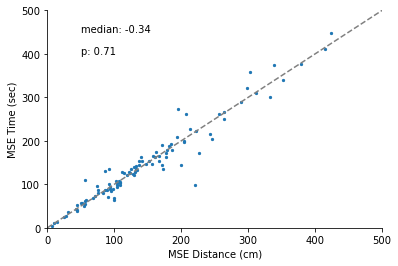

In [37]:
myDict={"distanceProp":{"name":"MSE Distance (prop.)"},
       "y":{"name":"MSE Y coordinates (cm)"},
        "x":{"name":"MSE X coordinates (cm)"},
        "x-y":{"name":"MSE X-Y coordinates (cm)"},
       "iTime":{"name":"MSE Time (sec)"},
       "targetDistance":{"name":"MSE Lever distance (cm)"},
       "distance":{"name":"MSE Distance (cm)"}}

fig,ax = plt.subplots(1,1)
mse_plot(ax,"distance","iTime",res,myDict)